# Continuous Ranked Probability Score (CRPS)

Uncertainty is inherent in forecasting. Full forecast information, whether objective or subjective, will describe a range of possibilities. 

Scalar forecasts, with a forecast expressed as the probability of not exceeding various thresholds, with sufficient thresholds to treat it as a continuous forecast distribution, can be compared to observations via the `crps_cdf` function.

An ensemble of scalar forecasts, designed to represent the range of possibilities, can be compared to observations via the `crps_for_ensemble` function.

The CRPS may be considered as the Mean Absolute Error of the forecast distribution with respect to the observed distribution. Smaller values represent more accurate forecasts.

Further reading can be found at         

  - Matheson, J. E., and R. L. Winkler, 1976: Scoring rules for continuous probability distributions.
            Manage. Sci.,22, 1087–1095.
  - Gneiting, T., & Ranjan, R. (2011). Comparing Density Forecasts Using Threshold- and
            Quantile-Weighted Scoring Rules.
            Journal of Business & Economic Statistics, 29(3), 411–422. http://www.jstor.org/stable/23243806

In [1]:
from scores.probability import crps_cdf
import matplotlib.pyplot as plt

import numpy
import scipy
import xarray

## Using the `crps_cdf` function

In [2]:
# Uncomment the following line and run to read the documentation regarding the crps_cdf funtion in scores.
# crps_cdf?

For the purpose of this tutorial, we will create a probabilistic forecast of temperature based on a normal distribution which we will compare to a single verifying observation.

In [3]:
fcst_thresholds = numpy.linspace(-2, 8, 100)  # Let's consider a range of forecast values between -2 and 8 degrees

Text(0, 0.5, 'Probability Density')

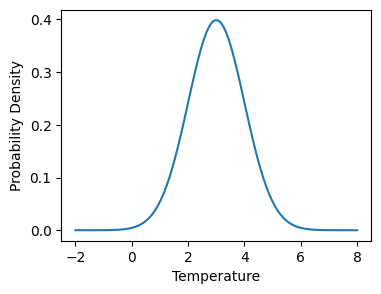

In [4]:
# Let's imagine the temperature will probably be around 3 degrees. We may imagine our forecast as per this graph 
fcst_pdf = scipy.stats.norm.pdf(fcst_thresholds, loc=3)
plt.figure(figsize=(4, 3))
plt.plot(fcst_thresholds, fcst_pdf)
plt.xlabel("Temperature")
plt.ylabel("Probability Density")

Text(0, 0.5, 'Probability')

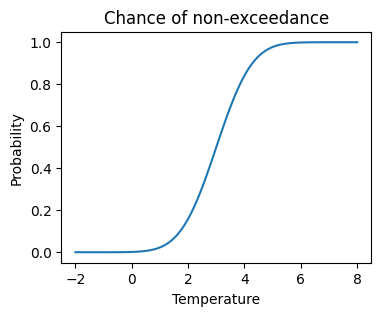

In [5]:
# We show the same function as a cumulative probability distribution (CDF). 
# Each point on the CDF gives the probability that the temperature will be X or lower.
# It is certain (probability 1) that the the temperature will be 6 or less. 
# It is pretty likely the temperature will be no more than 4 degrees. 
# There is a 50% chance of it being no more than 3 degrees.
fcst_cdf = scipy.stats.norm.cdf(fcst_thresholds, loc=3)
plt.figure(figsize=(4, 3))
plt.plot(fcst_thresholds, fcst_cdf)
plt.title("Chance of non-exceedance")
plt.xlabel("Temperature")
plt.ylabel("Probability")

Text(0, 0.5, 'Probability')

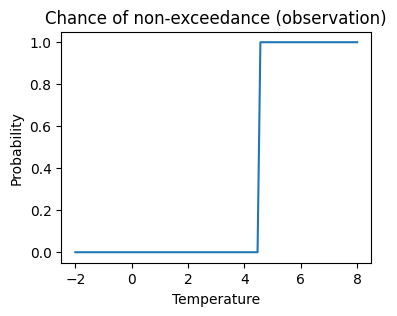

In [6]:
# Let's say we observed a temperature of 4.5 degrees. 
# Once we know the observation is 4.5, there is no chance of it being less than 4.4 degrees
# There is 100% chance of observing less than 4.6 degrees.
# The perfect forecast would have been a step function at temperature = 4.5. 
observed = 4.5
observed_cdf = numpy.heaviside(fcst_thresholds-observed, 1)
plt.figure(figsize=(4, 3))
plt.plot(fcst_thresholds, observed_cdf)
plt.title("Chance of non-exceedance (observation)")
plt.xlabel("Temperature")
plt.ylabel("Probability")

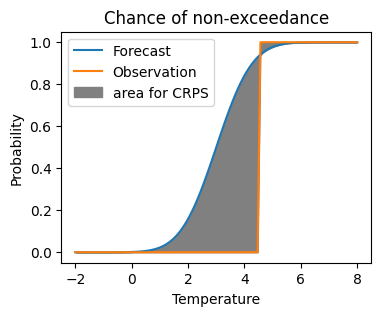

In [7]:
# We now compare the forecast cdf to the cdf representing the observation.
# The area of the difference between the two curves is the CRPS.
plt.figure(figsize=(4, 3))
plt.plot(fcst_thresholds, fcst_cdf, label='Forecast')
plt.plot(fcst_thresholds, observed_cdf, label='Observation')
plt.fill_between(fcst_thresholds, fcst_cdf, observed_cdf, color='gray', label='area for CRPS')
plt.title("Chance of non-exceedance")
plt.xlabel("Temperature")
plt.ylabel("Probability")
plt.legend(loc="upper left")

In [8]:
# To use the crps_cdf function we need the forecast to be an xarray with values giving the cdf (probability) at each of many thresholds (degrees C in this example)
fcst_array = xarray.DataArray(coords={'temperature': fcst_thresholds}, data=fcst_cdf)

# The observation is the value, but again provided in an xarray. We don't have to provide it as a CDF.
obs_array = xarray.DataArray(4.5)

# When working with real data you are likely to have coordinates for the forecast and observation representing the 
# location and time, allowing you to assess many forecasts at once.

In [9]:
# Here we calculate the CRPS for the forecast and observation above.
# Although not true in this example, the forecast might have had several dimensions. 
# We need to specify which forecast dimension provides the thresholds for calculating the CRPS. 
crps_cdf(fcst_array, obs_array, threshold_dim='temperature').total.values.round(3)

0.994

### Using the `threshold_weight` functionality.

Imagine you are interested in how severe a frost will be. Once the screen temperature is 4C or lower a ground frost is plausible. So, you do not care if the forecast and observations are both above 4C, but want to assess the forecast when it or the observation is less than 4C.  In this case, make a weighting function of 1 for forecast thresholds below 4, and 0 above 4 as below.

Note that the threshold_weights are different to weights that might be applied based on location (for example).

In [10]:
threshold_weights = xarray.DataArray(coords={'temperature': fcst_thresholds}, data=[1.0]*60 + [0]*40)

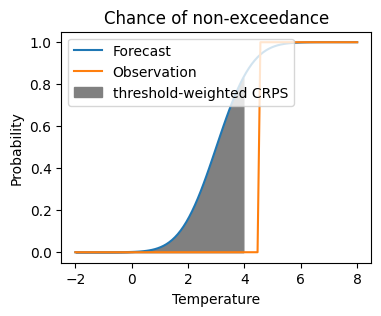

In [11]:
# The area with weight 0 is not included in the CRPS calculation.
# The area contributing to the CRPS calculation is shown below
plt.figure(figsize=(4, 3))
plt.plot(fcst_thresholds, fcst_cdf, label='Forecast')
plt.plot(fcst_thresholds, observed_cdf, label='Observation')
plt.fill_between(fcst_thresholds[fcst_thresholds<=4], fcst_cdf[fcst_thresholds<=4], observed_cdf[fcst_thresholds<=4], color='gray', label='threshold-weighted CRPS')
plt.title("Chance of non-exceedance")
plt.xlabel("Temperature")
plt.ylabel("Probability")
plt.legend(loc="upper left")

In [12]:
# Calculate the area of the threshold-weighted CRPS
crps_cdf(fcst_array, obs_array, threshold_dim='temperature', threshold_weight=threshold_weights).total.values.round(3)

0.639

### Things to try next

* Try modifing the forecast or observation in the example above to explore the response of the CRPS  
* Use crps_cdf with some forecasts and observations with extra dimensions in space and/or time.  
* Use the preserve_dims option to provde the CRPS in a less summarised version across the extra dimensions.  
* Compare the two integration methods, using limited forecast thresholds to make the difference more obvious.  
* Try more complicated threshold_weights than presented above.  
